## Background



In [1]:
import muq.Modeling as mm 
import muq.SamplingAlgorithms as ms 
import muq.Utilities as mu
import muq.Approximation as ma 

from FlowEquation import FlowEquation

import numpy as np
import matplotlib.pyplot as plt 

In [2]:
class Discretization:
    
    def __init__(self,numCells):
        self.numCells = numCells
        self.numNodes = numCells+1

        self.nodeLocs = np.linspace(0,1,numCells+1)

        self.cellLocs = 0.5*(self.nodeLocs[:-1] + self.nodeLocs[1:]).reshape(1,-1)

In [3]:
def GetTrueLogConductivity(mesh):
    return np.cos(10.0*mesh.cellLocs)

In [4]:
def GenerateData(mesh, obsThin, obsVar):

    # Generate the data
    numRefine = 1
    fineMesh = Discretization(numRefine*mesh.numCells)
    trueCond = np.exp( GetTrueLogConductivity(fineMesh) )

    # Create the model with twice the mesh resolution
    recharge = np.ones(fineMesh.numCells)
    mod = FlowEquation(recharge)

    # Solve the forward problem with the true conductivity
    trueSol = mod.Evaluate( trueCond )[0]

    # Take every N node as an "observation"
    slicer = mm.SliceOperator(fineMesh.numNodes,0,fineMesh.numCells,numRefine*obsThin)

    return slicer.Evaluate([trueSol])[0] + np.sqrt(obsVar)*np.random.randn(slicer.outputSizes[0])

In [5]:
def CreatePrior(mesh):
    
    # Define the prior distribution
    priorVar    = 1.0
    priorLength = 0.05
    priorNu     = 3.0/2.0
    
    covKernel = ma.MaternKernel(1, priorVar, priorLength, priorNu) # The first argument "1" specifies we are working in 1d
    
    meanFunc = ma.ZeroMean(1,1) # dimension of x, components in k(x) if it was vector-valued

    priorGP = ma.GaussianProcess(meanFunc,covKernel)

    return priorGP.Discretize(mesh.cellLocs)

In [6]:
def ConstructGraph(mesh, data, obsThin, obsVar):
   
    # Define the forward model
    recharge = np.ones(mesh.numCells)
    forwardMod = FlowEquation(recharge)
    
    graph = mm.WorkGraph()
    graph.AddNode(mm.IdentityOperator(mesh.numCells), "Log Conductivity")
    graph.AddNode(mm.ExpOperator(mesh.numCells), "Conductivity")
    graph.AddEdge("Log Conductivity", 0, "Conductivity", 0)

    graph.AddNode(forwardMod, "Forward Model")
    graph.AddEdge("Conductivity", 0, "Forward Model", 0)
    graph.AddNode(mm.SliceOperator(mesh.numNodes,0,mesh.numCells,obsThin), "Observables")
    graph.AddEdge("Forward Model", 0, "Observables", 0)
    
    
    priorDist = CreatePrior(mesh)
    likelihood = mm.Gaussian(data, obsVar*np.ones(data.shape[0]))

    graph.AddNode(likelihood.AsDensity(), "Likelihood")
    graph.AddEdge("Observables", 0, "Likelihood", 0)
    
    graph.AddNode(priorDist.AsDensity(), "Prior")
    graph.AddEdge("Log Conductivity", 0, "Prior", 0)
    
    graph.AddNode(mm.DensityProduct(2), "Posterior")
    graph.AddEdge("Prior",0,"Posterior",0)
    graph.AddEdge("Likelihood",0,"Posterior",1)

    graph.Visualize("WorkGraph.pdf")
    
    return graph

In [18]:
def SampleDILI(posterior, startPt, numSamps):
    
    lisOpts = {
        'Method' : "MHKernel",
        "Proposal" : "Prop",
        "Prop.Method" : "MALAProposal",
        "Prop.StepSize" : 0.15
    }
    
    csOpts = {
        "Method" : "MHKernel",
        "Proposal" : "Prop",
        "Prop.Method" : "CrankNicolsonProposal",
        "Prop.Beta" : 0.5,
        "Prop.PriorNode" : "Prior"
    }
    
    opts = {
        "NumSamples" : numSamps,
        "BurnIn" : 5000,
        "PrintLevel" : 3,
        "HessianType" : "Exact",
        "Adapt Interval" : 0,
        "Initial Weight" : 10,
        "Prior Node" : "Prior",
        "Likelihood Node" : "Likelihood",
        "LIS Block": "LIS",
        "LIS" : lisOpts,
        "CS Block": "CS",
        "CS" : csOpts
    }
    
    # create a sampling problem
    problem = ms.SamplingProblem(posterior)
    
    # Construct the DILI kernel and MCMC sampler
    kernel = ms.DILIKernel(opts, problem)
    sampler = ms.SingleChainMCMC(opts, [kernel])
    
    return sampler.Run([startPt]) 

In [19]:
def ComputeMAP(posterior, startPt):
    
    def objective(x):
        
        f = -posterior.Evaluate([x])[0]
        grad = -posterior.Gradient(0,0,[x],np.ones(1))
        
        return f, grad

    def HessianAction(x,vec):
        return -posterior.ApplyHessian(0,0,0,[x],np.ones(1),vec)
    
    import scipy.optimize as opt
    
    res = opt.minimize(objective, startPt, method='trust-ncg', jac=True, hessp=HessianAction, options={'disp': True})
    
    return res.x

In [20]:
def SamplePCN(posterior, startPt, numSamps):
    
    kernOpts = {
        "Method" : "MHKernel",
        "Proposal" : "Prop",
        "Prop.Method" : "CrankNicolsonProposal",
        "Prop.Beta" : 0.1,
        "Prop.PriorNode" : "Prior"
    }
    
    opts = {
        "NumSamples" : numSamps, # number of Monte Carlo samples,
        "BurnIn" : 5000,
        "PrintLevel" : 3,
        "KernelList" : "Kernel1",
        "Kernel1" : kernOpts
    }
    
    
    #create a sampling problem
    problem = ms.SamplingProblem(posterior)

    sampler = ms.SingleChainMCMC(opts,problem)

    return sampler.Run([startPt]) # Use a true posterior sample to avoid burnin

In [21]:
# Define the mesh
numCells = 100
mesh = Discretization(numCells)

# Generate synthetic "truth" data
obsThin = 10
obsVar = 0.01*0.01
data = GenerateData(mesh, obsThin, obsVar)

graph = ConstructGraph(mesh, data, obsThin, obsVar)
posterior = graph.CreateModPiece('Posterior')
model = graph.CreateModPiece('Forward Model')

# Use a random draw from the prior as a starting point for MCMC
startPt = CreatePrior(mesh).Sample()

mapPt = ComputeMAP(posterior, startPt)

Optimization terminated successfully.
         Current function value: -85.560957
         Iterations: 66
         Function evaluations: 65
         Gradient evaluations: 62
         Hessian evaluations: 1310


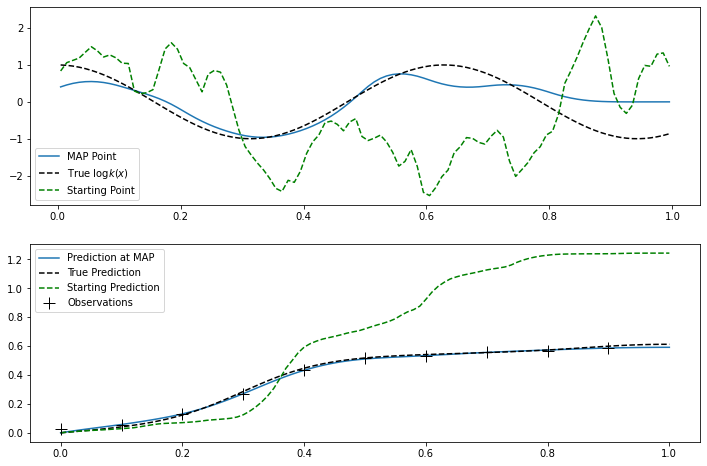

In [22]:
trueLogK = GetTrueLogConductivity(mesh).ravel()

fig, axs = plt.subplots(nrows=2,figsize=(12,8))
axs[0].plot(mesh.cellLocs.ravel(), mapPt,label='MAP Point')
axs[0].plot(mesh.cellLocs.ravel(), trueLogK, '--k', label='True $\log k(x)$')
axs[0].plot(mesh.cellLocs.ravel(), startPt, '--g', label='Starting Point')
axs[0].legend()

truePred = model.Evaluate([trueLogK])[0]
mapPred = model.Evaluate([mapPt])[0]
startPred = model.Evaluate([startPt])[0]

axs[1].plot(mesh.nodeLocs, mapPred, label='Prediction at MAP')
axs[1].plot(mesh.nodeLocs, truePred,'--k',label='True Prediction')
axs[1].plot(mesh.nodeLocs, startPred, '--g', label='Starting Prediction')
axs[1].plot(mesh.nodeLocs[0:-1:obsThin],data,'+k',markersize=12,label='Observations')
axs[1].legend()

plt.show()

In [23]:
numSamps = 200000
diliSamps = SampleDILI(posterior, mapPt, numSamps)
print("DILI Min ESS: ", diliSamps.ESS().min() )

Starting single chain MCMC sampler...
Setting lis with eigenvalues: 
 4104.97  147.555   42.927  21.7909  8.29921  7.18601  2.17423  0.91636 0.385711 0.172579 0.138883
  10% Complete
    Block 0:
       LIS (dim=11): MHKernel acceptance Rate = 42%
       CS: MHKernel acceptance Rate = 31%
  20% Complete
    Block 0:
       LIS (dim=11): MHKernel acceptance Rate = 42%
       CS: MHKernel acceptance Rate = 32%
  30% Complete
    Block 0:
       LIS (dim=11): MHKernel acceptance Rate = 40%
       CS: MHKernel acceptance Rate = 30%
  40% Complete
    Block 0:
       LIS (dim=11): MHKernel acceptance Rate = 41%
       CS: MHKernel acceptance Rate = 30%
  50% Complete
    Block 0:
       LIS (dim=11): MHKernel acceptance Rate = 39%
       CS: MHKernel acceptance Rate = 30%
  60% Complete
    Block 0:
       LIS (dim=11): MHKernel acceptance Rate = 39%
       CS: MHKernel acceptance Rate = 31%
  70% Complete
    Block 0:
       LIS (dim=11): MHKernel acceptance Rate = 39%
       CS: MHKernel 

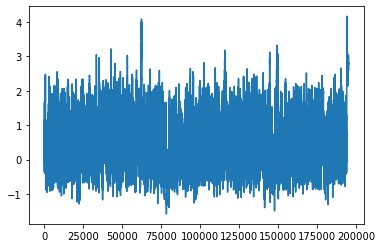

In [24]:
samps = diliSamps.AsMatrix()
plt.plot(samps[0,:])

(array([-10000,  -9999,  -9998, ...,   9998,   9999,  10000]),
 array([0.03056627, 0.03038303, 0.03023874, ..., 0.03023874, 0.03038303,
        0.03056627]),
 <matplotlib.lines.Line2D at 0x7fc36454d7f0>)

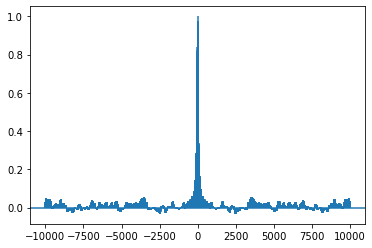

In [25]:
plotInd = 50
plt.acorr(samps[plotInd,:]-np.mean(samps[plotInd:]),maxlags=10000)

In [26]:
pcnSamps = SamplePCN(posterior, startPt, numSamps)
print("PCN Min ESS: ", pcnSamps.ESS().min())

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      MHKernel acceptance Rate = 12%
  20% Complete
    Block 0:
      MHKernel acceptance Rate = 12%
  30% Complete
    Block 0:
      MHKernel acceptance Rate = 12%
  40% Complete
    Block 0:
      MHKernel acceptance Rate = 12%
  50% Complete
    Block 0:
      MHKernel acceptance Rate = 12%
  60% Complete
    Block 0:
      MHKernel acceptance Rate = 12%
  70% Complete
    Block 0:
      MHKernel acceptance Rate = 12%
  80% Complete
    Block 0:
      MHKernel acceptance Rate = 12%
  90% Complete
    Block 0:
      MHKernel acceptance Rate = 12%
  100% Complete
    Block 0:
      MHKernel acceptance Rate = 12%
Completed in 86.786 seconds.
PCN Min ESS:  28.36791812592894


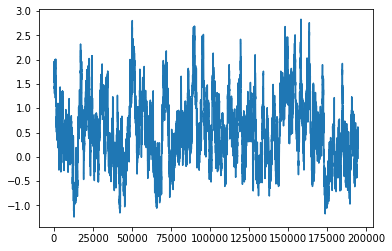

In [27]:
samps = pcnSamps.AsMatrix()
# print(samps.shape)

plt.plot(samps[0,:])

(array([-10000,  -9999,  -9998, ...,   9998,   9999,  10000]),
 array([-0.04813417, -0.04814892, -0.04817344, ..., -0.04817344,
        -0.04814892, -0.04813417]),
 <matplotlib.lines.Line2D at 0x7fc3503db280>)

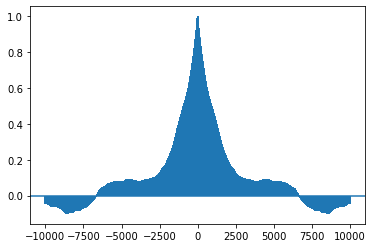

In [28]:
plt.acorr(samps[plotInd,:]-np.mean(samps[plotInd,:]),maxlags=10000)